<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>Using Great Circle distance to find nearby locations of interest <span class="tocSkip"></span></h1>

This notebook helps calculates great circle distances between pairs of two sets of locations (e.g. campsite and landmark), and identifies pairs that are within a certain distance. Once you have this information, you can identify types of landmarks that are within the distance to create 'attributes associated with the campsite', which can be used for further clustering analysis.

This uses Latitude and Longitude information -- if you only have street addresses, you need to geocode them, see the HERE Maps API for examples. 

The distance calculations functions are defined within the notebook. In future versions, we will move them to the utilities folder into re-usable .py files.

For questions, email daniel.wang@oliverwyman.com



<h1>Table of Contents<span class="tocSkip"></span></h1>
<ul class="toc-item"><li><span><a href="#Load-in-datasets" data-toc-modified-id="Load-in-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load in datasets</a></span><ul class="toc-item"><li><span><a href="#Rename-columns-to-have-the-same-name-for-Latitude-and-Longitude" data-toc-modified-id="Rename-columns-to-have-the-same-name-for-Latitude-and-Longitude-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Rename columns to have the same name for Latitude and Longitude</a></span></li></ul></li><li><span><a href="#Calculate-Great-Circle-distance-matrix" data-toc-modified-id="Calculate-Great-Circle-distance-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate Great Circle distance matrix</a></span></li><li><span><a href="#Option-1:-Identify-nearest-Place-to-each-campsite" data-toc-modified-id="Option-1:-Identify-nearest-Place-to-each-campsite-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Option 1: Identify nearest Place to each campsite</a></span><ul class="toc-item"><li><span><a href="#Assign-a-number-to-each-Place-Name-(for-coloring-the-plots)" data-toc-modified-id="Assign-a-number-to-each-Place-Name-(for-coloring-the-plots)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Assign a number to each Place Name (for coloring the plots)</a></span></li><li><span><a href="#Plot-on-a-grid" data-toc-modified-id="Plot-on-a-grid-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot on a grid</a></span></li><li><span><a href="#Plot-on-a-map" data-toc-modified-id="Plot-on-a-map-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Plot on a map</a></span></li></ul></li><li><span><a href="#Find-all-landmarks-within-X-miles-from-campsite" data-toc-modified-id="Find-all-landmarks-within-X-miles-from-campsite-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Find all landmarks within X miles from campsite</a></span></li></ul>

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load in datasets

In [2]:
dataset = pd.read_csv("sample_input/campsites.csv")
dataset.head()

,FacilityID,CampsiteName,CampsiteLongitude,CampsiteLatitude
0,232446,65,-119.683914,37.550125
1,232447,44,-119.565040,37.737625
2,232451,78,-119.866541,37.799589
3,232709,9,-97.264983,31.586164
4,251938,32,-84.485965,35.076028


In [3]:
landmarks = pd.read_csv("sample_input/landmarks.csv")
landmarks.head()

,Place Name,Latitude,Longitude
0,"Castle Clinton National Monument, NY, USA",40.703636,-74.017288
1,"Papahanaumokuakea Marine National Monument, Ha...",25.700001,-171.733337
2,"Crazy Cook Monument, Hachita, NM, USA",31.496918,-108.208885
3,"Organ Pipe Cactus National Monument, Ajo, AZ, USA",32.089806,-112.905861
4,"Pipe Spring National Monument, Fredonia, AZ, USA",36.863136,-112.739746


## Rename columns to have the same name for Latitude and Longitude

In [4]:
dataset = dataset.rename(columns={"CampsiteLongitude": "Longitude",
                                  "CampsiteLatitude": "Latitude"})

# Calculate Great Circle distance matrix

In [5]:
# Generic function for calculating great circle distance, vectorized
def great_circle_distance(lon1, lat1, lon2, lat2, unit='miles'):
    """    
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    # convert decimal degrees to radians    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])    # haversine formula    
    dlon = lon2 - lon1    
    dlat = lat2 - lat1    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2    
    c = 2 * np.arcsin(np.sqrt(a))    
    
    if unit in ["miles", "mile"]:
        r = 3958.756 # Radius of earth in miles
    elif unit in ["km", "kilometer", "kilometers"]:
        r = 6371.0 # Radius of earth in kms

    return c * r

# Function for getting closest distance only.  
def get_all_distances(origin, targets, lon_column="Lon", lat_column="Lat", unit='miles', append_origin=False):
    """
    Great circle distance between an origin (single row in dataframe) and a dataframe with target destinations. 
    lon_column is the column name containing Longitude
    lat_column is the column name containing Latitude
    append_origin should be true to add the origin information
    """
    
    targets = targets.copy()
    
    targets['great_circle_distance'] = great_circle_distance(origin[lon_column], origin[lat_column], 
                                                             targets[lon_column], targets[lat_column])
    
    
    if append_origin:
        for col in origin.index:
            targets["Origin: {}".format(col)] = origin[col]

    return targets



In [6]:
output_list = []

nrows = dataset.shape[0]
for index, row in dataset.iterrows():
    
    if index % 100==0: print("Processing {} out of {} items".format(index+1, nrows+1))
    
    result = get_all_distances(row, targets = landmarks, lon_column="Longitude", lat_column="Latitude", unit='miles', append_origin=True)
    
    output_list.append(result)

Processing 1 out of 1001 items
Processing 101 out of 1001 items
Processing 201 out of 1001 items
Processing 301 out of 1001 items
Processing 401 out of 1001 items
Processing 501 out of 1001 items
Processing 601 out of 1001 items
Processing 701 out of 1001 items
Processing 801 out of 1001 items
Processing 901 out of 1001 items


In [7]:
distance_results = pd.concat(output_list)

In [8]:
distance_results.head()

,Place Name,Latitude,Longitude,great_circle_distance,Origin: FacilityID,Origin: CampsiteName,Origin: Longitude,Origin: Latitude
0,"Castle Clinton National Monument, NY, USA",40.703636,-74.017288,2429.822152,232446,65,-119.683914,37.550125
1,"Papahanaumokuakea Marine National Monument, Ha...",25.700001,-171.733337,3128.595417,232446,65,-119.683914,37.550125
2,"Crazy Cook Monument, Hachita, NM, USA",31.496918,-108.208885,774.726048,232446,65,-119.683914,37.550125
3,"Organ Pipe Cactus National Monument, Ajo, AZ, USA",32.089806,-112.905861,538.346813,232446,65,-119.683914,37.550125
4,"Pipe Spring National Monument, Fredonia, AZ, USA",36.863136,-112.739746,384.983563,232446,65,-119.683914,37.550125


# Option 1: Identify nearest Place to each campsite

In [9]:
closest_location_only = distance_results.sort_values(by=['Origin: FacilityID', 'great_circle_distance']).groupby('Origin: FacilityID').first().reset_index()

In [10]:
closest_location_only.head()

,Origin: FacilityID,Place Name,Latitude,Longitude,great_circle_distance,Origin: CampsiteName,Origin: Longitude,Origin: Latitude
0,15045,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,281.509483,A-1,-111.853544,43.961886
1,202155,"Delicate Arch, Arches National Park, Utah, USA",38.743629,-109.499313,16.959970,Hunter Canyon Group Site,-109.597027,38.510336
2,231836,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,357.256253,24,-104.423472,44.426862
3,231837,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,360.054759,5,-103.512620,43.775080
4,231838,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,350.417746,3,-103.713975,43.735366


## Assign a number to each Place Name (for coloring the plots)

In [11]:
closest_location_only['PlaceNameID'] = pd.factorize(closest_location_only['Place Name'])[0]
closest_location_only.head()

,Origin: FacilityID,Place Name,Latitude,Longitude,great_circle_distance,Origin: CampsiteName,Origin: Longitude,Origin: Latitude,PlaceNameID
0,15045,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,281.509483,A-1,-111.853544,43.961886,0
1,202155,"Delicate Arch, Arches National Park, Utah, USA",38.743629,-109.499313,16.959970,Hunter Canyon Group Site,-109.597027,38.510336,1
2,231836,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,357.256253,24,-104.423472,44.426862,0
3,231837,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,360.054759,5,-103.512620,43.775080,0
4,231838,"Dinosaur National Monument, Jensen, UT, USA",40.490456,-108.971474,350.417746,3,-103.713975,43.735366,0


In [12]:
# Random permutation of IDs
starting_order = list(closest_location_only['PlaceNameID'].unique())
random_order = np.random.permutation(starting_order)
closest_location_only['PlaceNameID'] = closest_location_only['PlaceNameID'].map(dict(zip(starting_order, random_order)))

## Plot on a grid

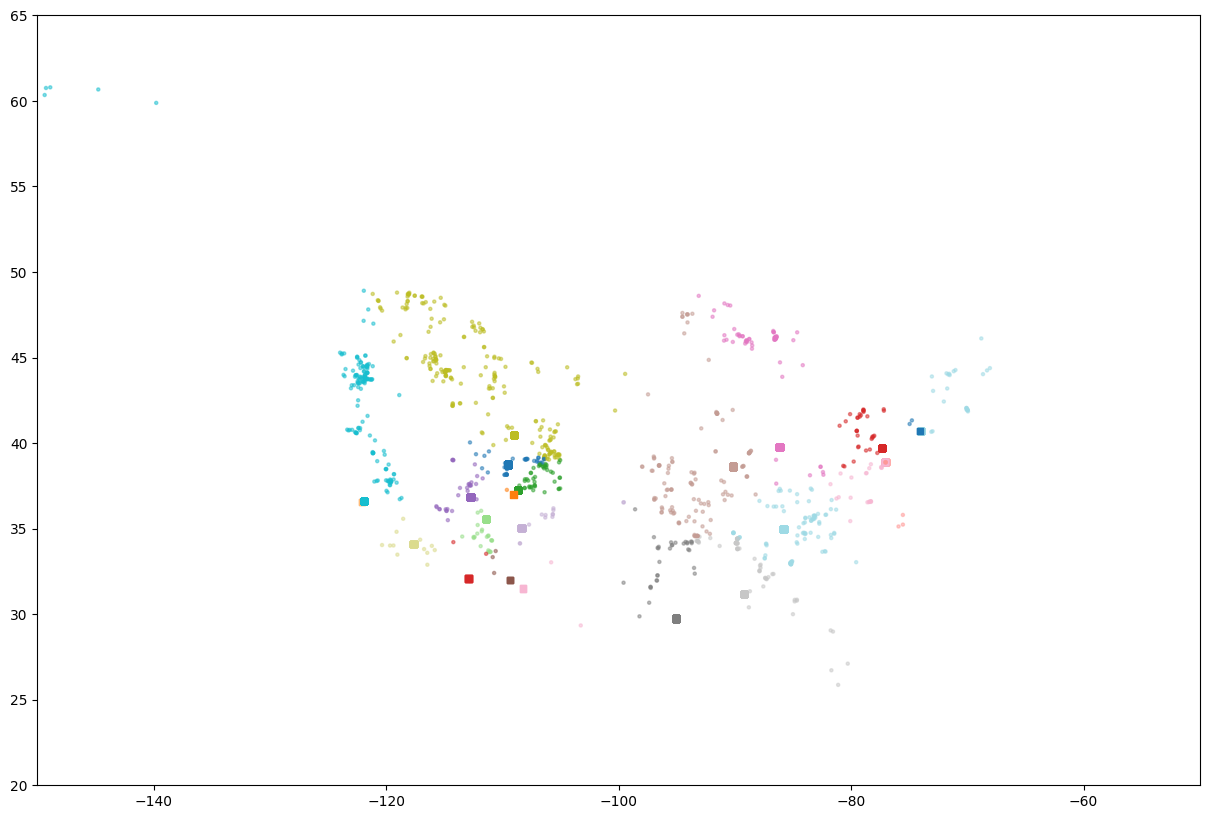

In [13]:
plt.figure(figsize=(15,10)) # Figure size

# Plot of the landmarks (monuments)
plt.scatter(closest_location_only['Longitude'], closest_location_only['Latitude'], c = closest_location_only['PlaceNameID'],
            s = 20,
            alpha = 1,
            cmap = plt.colormaps.get_cmap('tab20'),
            marker = 's'
           )

# Plots of the campsites
plt.scatter(closest_location_only['Origin: Longitude'], closest_location_only['Origin: Latitude'], c = closest_location_only['PlaceNameID'],
            s = 5, # Size of scatter 
            alpha=0.5, # Transparency
            cmap = plt.colormaps.get_cmap('tab20') # Get more distinct colors. This cycles between 10 colors
           ) 
            
plt.xlim(-150, -50)  # Set x-axis limits
plt.ylim(20, 65)  # Set y-axis limits
plt.show()

## Plot on a map

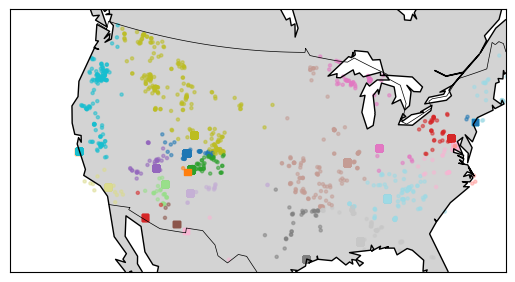

In [17]:
# Create a basemap instance for the United States
my_map = Basemap(llcrnrlon=-125, llcrnrlat=24, urcrnrlon=-66, urcrnrlat=50, projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

# Draw the map boundaries
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='lightgray')

# Convert longitude and latitude to map coordinates
x, y = my_map(closest_location_only['Longitude'], closest_location_only['Latitude'])

# Plot of the landmarks (monuments)
plt.scatter(x, y, c = closest_location_only['PlaceNameID'],
            s = 20,
            alpha = 1,
            cmap = plt.colormaps.get_cmap('tab20'),
            marker = 's'
           )

# Plots of the campsites
x1, y1 = my_map(closest_location_only['Origin: Longitude'], closest_location_only['Origin: Latitude'])
plt.scatter(x1, y1, c = closest_location_only['PlaceNameID'],
            s = 5, # Size of scatter 
            alpha=0.5, # Transparency
            cmap = plt.colormaps.get_cmap('tab20') # Get more distinct colors. This cycles between 10 colors
           ) 

plt.show()

# Find all landmarks within X miles from campsite

In [18]:
# Starting from all the distances
distance_results.head()

,Place Name,Latitude,Longitude,great_circle_distance,Origin: FacilityID,Origin: CampsiteName,Origin: Longitude,Origin: Latitude
0,"Castle Clinton National Monument, NY, USA",40.703636,-74.017288,2429.822152,232446,65,-119.683914,37.550125
1,"Papahanaumokuakea Marine National Monument, Ha...",25.700001,-171.733337,3128.595417,232446,65,-119.683914,37.550125
2,"Crazy Cook Monument, Hachita, NM, USA",31.496918,-108.208885,774.726048,232446,65,-119.683914,37.550125
3,"Organ Pipe Cactus National Monument, Ajo, AZ, USA",32.089806,-112.905861,538.346813,232446,65,-119.683914,37.550125
4,"Pipe Spring National Monument, Fredonia, AZ, USA",36.863136,-112.739746,384.983563,232446,65,-119.683914,37.550125


In [20]:
# Get the distance matrix across all locations
distance_matrix = distance_results[['Origin: FacilityID', 'Place Name', 'great_circle_distance']].pivot(index = 'Origin: FacilityID', columns='Place Name', values='great_circle_distance')

In [21]:
distance_matrix.head()

Place Name,"California Coastal National Monument, Crescent City, CA, USA","Camp Shelby, Hattiesburg, MS, USA","Castle Clinton National Monument, NY, USA","Chiricahua National Monument, Willcox, AZ, USA","Crazy Cook Monument, Hachita, NM, USA","Delicate Arch, Arches National Park, Utah, USA","Dinosaur National Monument, Jensen, UT, USA","El Morro National Monument, El Morro, NM, USA","Four Corners Monument, Teec Nos Pos, AZ, USA","Lincoln Memorial, Washington DC, USA",...,"Pipe Spring National Monument, Fredonia, AZ, USA","Presidio of Monterey, Monterey, CA, USA","Russell Cave National Monument, Bridgeport, AL, USA","San Jacinto Monument, La Porte, TX, USA","Soldiers & Sailors Monument, IN, USA","The Gateway Arch, St. Louis, MO, USA","The Statue of Liberty National Monument, USA","Washington Monument, USA","Wupatki National Monument, Flagstaff, AZ, USA","Yucca House National Monument, Cortez, CO, USA"
Origin: FacilityID,,,,,,,,,,,,,,,,,,,,,
15045,741.728908,1513.435046,1928.561144,836.646957,883.724565,380.615148,281.509483,644.083609,503.133854,1822.714747,...,492.677988,733.452170,1512.876456,1345.355694,1347.681067,1179.707433,1927.547072,1823.472210,581.861437,492.542557
202155,695.142712,1258.137583,1887.086934,449.076636,490.888021,16.959970,140.818112,249.637086,108.688099,1745.783036,...,206.088816,686.780820,1335.275400,1025.328340,1255.501214,1046.761224,1885.796029,1746.594923,227.362946,100.280402
231836,1071.170547,1230.997194,1559.281116,897.787825,916.580402,472.009988,357.256253,681.155878,567.186697,1456.311755,...,679.827761,1062.563626,1180.924159,1135.499549,987.657411,836.900666,1558.273008,1457.059217,715.213965,543.486604
231837,1095.555231,1167.230231,1515.442455,871.969649,885.995203,466.151645,360.054759,656.222683,551.027214,1407.216595,...,680.612864,1086.910498,1120.205312,1074.164157,934.103119,777.624807,1514.391057,1407.973973,705.510566,526.203737
231838,1085.188653,1172.700410,1525.594141,865.534467,880.282346,457.251543,350.417746,649.585309,543.218919,1417.012993,...,671.283271,1076.544348,1127.960278,1076.581532,943.439248,785.873520,1524.540560,1417.771213,697.088779,518.509271


In [24]:
# Identify landmarks within 100 miles
nearby_locations = 1*(distance_matrix <= 100)
nearby_locations

Place Name,"California Coastal National Monument, Crescent City, CA, USA","Camp Shelby, Hattiesburg, MS, USA","Castle Clinton National Monument, NY, USA","Chiricahua National Monument, Willcox, AZ, USA","Crazy Cook Monument, Hachita, NM, USA","Delicate Arch, Arches National Park, Utah, USA","Dinosaur National Monument, Jensen, UT, USA","El Morro National Monument, El Morro, NM, USA","Four Corners Monument, Teec Nos Pos, AZ, USA","Lincoln Memorial, Washington DC, USA",...,"Pipe Spring National Monument, Fredonia, AZ, USA","Presidio of Monterey, Monterey, CA, USA","Russell Cave National Monument, Bridgeport, AL, USA","San Jacinto Monument, La Porte, TX, USA","Soldiers & Sailors Monument, IN, USA","The Gateway Arch, St. Louis, MO, USA","The Statue of Liberty National Monument, USA","Washington Monument, USA","Wupatki National Monument, Flagstaff, AZ, USA","Yucca House National Monument, Cortez, CO, USA"
Origin: FacilityID,,,,,,,,,,,,,,,,,,,,,
15045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
202155,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10214711,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10214735,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10214768,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


**If you then mapped each landmark to a type of landmark (imagine if the landmarks included more than just monuments, but also other points of interest), then you can identify whether a campsite is near e.g. 'boat ramp', 'beach', 'monument', 'national park', etc. And use that for clustering to find campsites with similar characteristics**

In [31]:
# Get a list of locations
list_of_locations = nearby_locations.apply(lambda x: [colname for colname in nearby_locations.columns if x[colname] == 1], axis=1)
list_of_locations = list_of_locations.reset_index().rename(columns={0:"Nearby"})
list_of_locations['Number of Nearby'] = list_of_locations['Nearby'].apply(lambda x:len(x))
list_of_locations

,Origin: FacilityID,Nearby,Number of Nearby
0,15045,[],0
1,202155,"[Delicate Arch, Arches National Park, Utah, USA]",1
2,231836,[],0
3,231837,[],0
4,231838,[],0
...,...,...,...
995,10214711,"[Four Corners Monument, Teec Nos Pos, AZ, USA,...",2
996,10214735,"[Delicate Arch, Arches National Park, Utah, US...",3
997,10214768,"[Delicate Arch, Arches National Park, Utah, US...",3
998,10220609,[],0
